In [11]:
# Install PyWake if needed
import py_wake

In [12]:
from py_wake.deficit_models import *
from py_wake.deficit_models.deficit_model import *
from py_wake.wind_farm_models import *
from py_wake.rotor_avg_models import *
from py_wake.superposition_models import *
from py_wake.deflection_models import *
from py_wake.turbulence_models import *
from py_wake.ground_models import *
from py_wake.deficit_models.utils import *
import matplotlib.pyplot as plt
from py_wake.site import UniformSite
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from py_wake.site import UniformWeibullSite
import numpy as np


Initial layout has 198 wind turbines


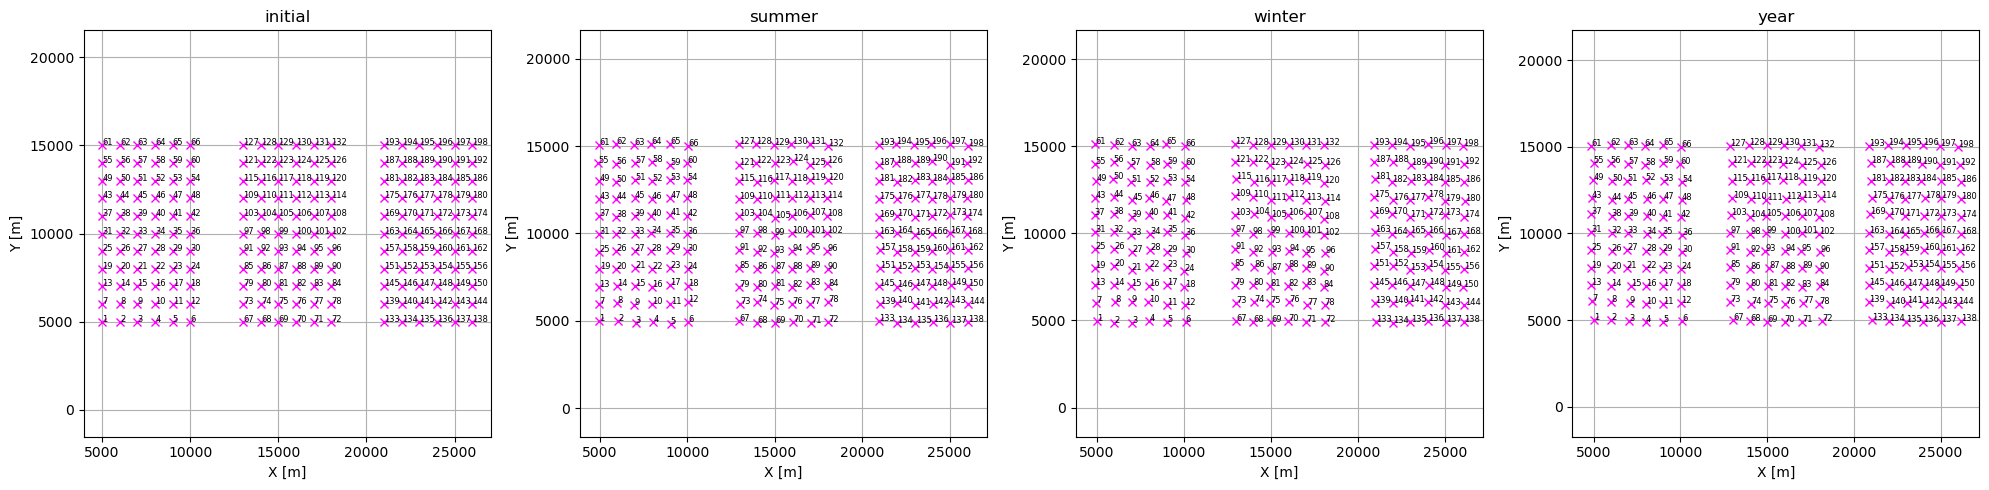

In [13]:
from py_wake.examples.data.iea37._iea37 import IEA37Site, IEA37_WindTurbines
import xarray as xr

select_layout = "initial"  # Options: "initial", "summer", "winter", "year"


# Load custom .ideal layouts
layout_file = "farm_custom.ideal"
layout_summer_opt = "optimized_layout_summer_100.ideal"
layout_winter_opt = "optimized_layout_winter_100.ideal"
layout_year_opt = "optimized_layout_year_100.ideal"
As_year, ks_year, freqs_year = np.load("As_year.npy"), np.load("ks_year.npy"), np.load("freqs_year.npy")

# Wind data from mesoscale model
wp0 = xr.open_dataset("C:\\Users\\annem\\OneDrive - Danmarks Tekniske Universitet\\General\\Testing_materials\\Data_Share\\condense_WP0.nc")
wp1 = xr.open_dataset("C:\\Users\\annem\\OneDrive - Danmarks Tekniske Universitet\\General\\Testing_materials\\Data_Share\\condense_WP1.nc")
full_wd = np.arange(0, 360, 5)  # wind directions
full_ws = np.arange(3, 25, 1)  # wind speeds
ws = wp0.WS.isel(time=0, height=3).values.flatten()  # shape (N,) -> all turbines
wd = wp0.WD.isel(time=0, height=3).values.flatten()  # shape (N,) -> all turbines

# --- Helper to read .ideal files ---
def read_layout(path):
    with open(path, "r") as f:
        lines = [line.strip().split() for line in f if not line.lower().startswith("latlon")]
    x = np.array([float(line[2]) for line in lines]) * 1000  # km to m
    y = np.array([float(line[1]) for line in lines]) * 1000
    return x, y
X_init, Y_init = read_layout("farm_custom.ideal")
X_summer, Y_summer = read_layout("optimized_layout_summer_100.ideal")
X_winter, Y_winter = read_layout("optimized_layout_winter_100.ideal")
X_year, Y_year     = read_layout("optimized_layout_year_100.ideal")

# Choose the layout to use
if select_layout == "initial":
    X_full, Y_full = X_init, Y_init  # initial layout
elif select_layout == "summer":
    X_full, Y_full = X_summer, Y_summer
elif select_layout == "winter":
    X_full, Y_full = X_winter, Y_winter
elif select_layout == "year":
    X_full, Y_full = X_year, Y_year

# --- Load all layouts ---
layouts = {
    "initial": read_layout("farm_custom.ideal"),
    "summer": read_layout("optimized_layout_summer_100.ideal"),
    "winter": read_layout("optimized_layout_winter_100.ideal"),
    "year":   read_layout("optimized_layout_year_100.ideal"),
}
n_wt = len(layouts["initial"][0])
print(f"Initial layout has {n_wt} wind turbines")

# --- Plot all layouts next to each other ---
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for ax, (title, (X, Y)) in zip(axs, layouts.items()):
    ax.plot(X, Y, "x", c="magenta")
    for i in range(len(X)):
        ax.text(X[i] + 10, Y[i], str(i + 1), fontsize=6)
    ax.set_title(title)
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    ax.axis("equal")
    ax.grid(True)

plt.tight_layout()
plt.show()

"""
turbines = []
with open(layout_file, "r") as f:
    for line in f:
        if line.strip().lower() == "latlon":
            continue  # Skip header
        parts = line.strip().split()
        if len(parts) >= 5:
            n_turbines = float(parts[0])
            y_grid = float(parts[1])
            x_grid = float(parts[2])
            turbines.append((x_grid, y_grid))  # Note: x first for consistency
# Convert to numpy arrays
X_full = np.array([t[0] for t in turbines])
Y_full = np.array([t[1] for t in turbines])
X_full = X_full* 1000.0  # Convert to km
Y_full = Y_full* 1000.0  # Convert to km
n_wt = len(X_full)
print(f"Initial layout has {n_wt} wind turbines")
initial_position = np.array([X_full, Y_full]).T  # shape (N, 2)
"""

"""

site = UniformWeibullSite(
    freqs_summer,   # p_wd (probability per wind direction)
    full_wd,        # wd (wind direction bins)
    As_summer,      # Weibull scale parameter A
    ks_summer,      # Weibull shape parameter k
)
"""
windTurbines = IEA37_WindTurbines()
#site = IEA37Site(16)
x, y = X_full, Y_full

site = UniformWeibullSite(p_wd=freqs_year,
                          a=As_year,
                          k=ks_year,
                          ti=0.1)  # turbulence intensity, optional


In [14]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension install --py widgetsnbextension --sys-prefix

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert run script server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--j

In [15]:
# prepare for the model combination tool
from py_wake.utils.model_utils import get_models, get_signature
from ipywidgets import interact
from IPython.display import HTML, display, Javascript
import time
import matplotlib.pyplot as plt

# Fix ipywidget label width
display(HTML('''<style>.widget-label { min-width: 20ex !important; }</style>'''))

def print_signature(windFarmModel, **kwargs):
    s = """# windFarmModel autogenerated by dropdown boxes
t = time.time()
wfm = %s
sim_res = wfm(x,y)
plt.figure(figsize=(12,8))
sim_res.flow_map(wd=270).plot_wake_map()
print (wfm)
print ("Computation time (AEP + flowmap):", time.time()-t)
plt.title('AEP: %%.2fGWh'%%(sim_res.aep().sum()))"""% get_signature(windFarmModel, kwargs, 1)
    # Write windFarmModel code to cell starting "# windFarmModel autogenerated by dropdown boxes"
    display(Javascript("""
for (var cell of IPython.notebook.get_cells()) {
    if (cell.get_text().startsWith("# windFarmModel autogenerated by dropdown boxes")){
        cell.set_text(`%s`);
        cell.execute();
    }
}"""%s))

# setup list of models
models = {n:[(getattr(m,'__name__',m), m) for m in get_models(cls)]
          for n,cls in [('windFarmModel', WindFarmModel),
                        ('wake_deficitModel', WakeDeficitModel),
                        ('rotorAvgModel', RotorAvgModel),
                        ('superpositionModel', SuperpositionModel),
                        ('blockage_deficitModel', BlockageDeficitModel),
                        ('deflectionModel',DeflectionModel),
                        ('turbulenceModel', TurbulenceModel),
                        ('groundModel', GroundModel)
                        ]}

In [16]:
_ = interact(print_signature, **models)

interactive(children=(Dropdown(description='windFarmModel', options=(('PropagateDownwind', <class 'py_wake.win…

In [ ]:
# windFarmModel autogenerated by dropdown boxes
t = time.time()
wfm = PropagateDownwind(
    site,
    windTurbines,
    wake_deficitModel=NOJDeficit(
        k=0.1,
        rotorAvgModel=AreaOverlapAvgModel(),
        groundModel=None),
    superpositionModel=LinearSum(),
    deflectionModel=None,
    turbulenceModel=None,
    rotorAvgModel=None)
#sim_res = wfm(x,y)
print("x shape:", x.shape)
print("y shape:", y.shape)
print("wd shape:", wd.shape)
print("ws shape:", ws.shape)

print(site.__class__)  # should say <class 'py_wake.site._uniform_site.UniformWeibullSite'>
print("X_full shape:", X_full.shape)
print("Y_full shape:", Y_full.shape)

# Ensure wind directions and wind speeds are consistent
#wd, ws = summer_resource_sample()

# Use the sampled wind directions and speeds directly
print("Sampled wind directions (wd):", wd)
print("Sampled wind speeds (ws):", ws)
# Ensure X_full and Y_full are 1D arrays with the same length
X_full = np.array(X_full).flatten().astype(np.float64)
Y_full = np.array(Y_full).flatten().astype(np.float64)
assert X_full.shape == Y_full.shape, "X_full and Y_full must have the same shape"

sampled_wd = np.array(wd).flatten().astype(np.float64)
sampled_ws = np.array(ws).flatten().astype(np.float64)

# Run the simulation with reduced wind directions and wind speeds
sim_res = wfm(x, y, wd=sampled_wd, ws=sampled_ws)

# Plot the wake map for the first wind direction in the sampled data
plt.figure(figsize=(12, 8))
sim_res.flow_map(wd=sampled_wd[0]).plot_wake_map()

print (wfm)
print ("Computation time (AEP + flowmap):", time.time()-t)
plt.title('AEP: %.2fGWh'%(sim_res.aep().sum()))
$
plt.savefig("wake_map{select_layout}.png", dpi=300, bbox_inches='tight')

x shape: (198,)
y shape: (198,)
wd shape: (2925,)
ws shape: (2925,)
<class 'py_wake.site.xrsite.UniformWeibullSite'>
X_full shape: (198,)
Y_full shape: (198,)
Sampled wind directions (wd): [50.344788 49.321564 48.165283 ... 30.742188 33.894196 44.979736]
Sampled wind speeds (ws): [12.063202 12.020762 11.979556 ...  7.423035  7.26063   7.368253]


MemoryError: Unable to allocate 104. MiB for an array with shape (1, 152, 300, 300) and data type float64